In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
pd.options.display.max_columns = None
import cPickle as pickle
from IPython.display import Image
from util import *

In [251]:
building_df = pd.read_csv('../data/buildings.csv')
all_df = pd.DataFrame()
all_df['building_id'] = building_df['building_id']
num_all = len(all_df)

In [248]:
pre_train_df = pd.read_csv('../data/train.csv')
num_train = len(train_df)

In [10]:
with open('incident_to_building_mapping.dump', 'r') as f:
    incident_to_building_mapping = pickle.load(f)

## Violation Features

In [5]:
violations = pd.read_csv('../data/violations.csv')

C:\Users\linghao\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (6,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
violations.head(3)

,TicketID,TicketNumber,AgencyName,ViolName,ViolationStreetNumber,ViolationStreetName,MailingStreetNumber,MailingStreetName,MailingCity,MailingState,MailingZipCode,NonUsAddressCode,Country,TicketIssuedDT,TicketIssuedTime,HearingDT,CourtTime,ViolationCode,ViolDescription,Disposition,FineAmt,AdminFee,LateFee,StateFee,CleanUpCost,JudgmentAmt,PaymentStatus,Void,ViolationCategory,ViolationAddress,MailingAddress,incident_id
0,26288,05000001DAH,Department of Public Works,"Group, LLC, Grand Holding",2566,GRAND BLVD,743,"Beaubien, Ste. 201",Detroit,MI,48226,NaN,NaN,01/01/38440 12:00:00 AM,12:00:00,01/01/38474 12:00:00 AM,9:00AM,22-2-20,Burning solid waste in open fires,Responsible By Determination,$1500.00,$20.00,$150.00,$10.00,$0.00,$1680.00,PAID IN FULL,0,0,"2566 GRAND BLVD\r\nDetroit, MI\r\n(42.36318237...","743 Beaubien\r\nDetroit, MI 48226\r\n(42.33373...",7133
1,19800,05000025DAH,Department of Public Works,"JACKSON, RAECHELLE",19014,ASHTON,20501,HEYDEN,DETROIT,MI,48219,NaN,NaN,01/01/38383 12:00:00 AM,10:15:00,01/01/38425 12:00:00 AM,1:30PM,22-2-22,Bulk solid waste deposited more than 24 hours ...,Not responsible By Determination,$100.00,$20.00,$10.00,$10.00,$0.00,$140.00,NO PAYMENT APPLIED,0,0,"19014 ASHTON\r\nDetroit, MI\r\n(42.42939076200...","20501 HEYDEN\r\nDETROIT, MI 48219\r\n(42.44217...",7134
2,19804,05000026DAH,Department of Public Works,"TALTON, CAROL ANN",18735,STAHELIN,18735,STAHELI N,DETROIT,MI,48219,NaN,NaN,01/01/38383 12:00:00 AM,10:35:00,01/01/38425 12:00:00 AM,1:30PM,22-2-22,Bulk solid waste deposited more than 24 hours ...,Responsible By Determination,$100.00,$20.00,$10.00,$10.00,$0.00,$140.00,PAID IN FULL,0,0,"18735 STAHELIN\r\nDetroit, MI\r\n(42.428707459...","18735 STAHELI N\r\nDETROIT, MI 48219\r\n(42.42...",7135


In [49]:
def clean_amt(s):
    try:
        s = str(s)
        s = s.replace('$', '')
        s = float(s)
        return s
    except Exception, e:
        return str(e)

In [50]:
violations['CleanJudgmentAmt'] = violations['JudgmentAmt'].map(clean_amt)

In [18]:
violations['JudgmentAmt'].isnull().sum()

1972

In [52]:
violations['CleanJudgmentAmt'].describe()

count    305832.000000
mean        425.211903
std         726.368971
min           0.000000
25%         140.000000
50%         305.000000
75%         305.000000
max       11030.000000
Name: CleanJudgmentAmt, dtype: float64

In [55]:
violations['CleanJudgmentAmt'].fillna(violations['CleanJudgmentAmt'].mean(), axis=0, inplace=True)

In [59]:
violations['Void'].value_counts()

0    99133
Name: Void, dtype: int64

In [61]:
violations['ViolationCategory'].value_counts()

0    305787
1      2017
Name: ViolationCategory, dtype: int64

In [62]:
violations['PaymentStatus'].value_counts()

NO PAYMENT APPLIED      244303
PAID IN FULL             44319
NO PAYMENT ON RECORD     14565
PARTIAL PAYMENT MADE      4617
Name: PaymentStatus, dtype: int64

In [76]:
violation_category_table = {
    0: 'violation_category_0_count',
    1: 'violation_category_1_count'
}

violation_payment_status_table = {
    'NO PAYMENT APPLIED': 'violation_no_pay_applied_count',
    'PAID IN FULL': 'violation_full_pay_count',
    'NO PAYMENT ON RECORD': 'violation_no_pay_on_rec_count',
    'PARTIAL PAYMENT MADE': 'violation_partial_pay_count'
}

In [252]:
all_df['violation_count'] = np.zeros(num_all)
all_df['violation_judgement_amount'] = np.zeros(num_all)
all_df['violation_category_0_count'] = np.zeros(num_all)
all_df['violation_category_1_count'] = np.zeros(num_all)
all_df['violation_no_pay_applied_count'] = np.zeros(num_all)
all_df['violation_full_pay_count'] = np.zeros(num_all)
all_df['violation_no_pay_on_rec_count'] = np.zeros(num_all)
all_df['violation_partial_pay_count'] = np.zeros(num_all)

for index, row in violations.iterrows():
    incident_id = row['incident_id']
    building_id = incident_to_building_mapping.get(incident_id, None)
    if not building_id:
        continue
    building_indexs = all_df[all_df['building_id'] == building_id].index.tolist()
    if not building_indexs:
        continue
    i = building_indexs[0]
    all_df.loc[i, 'violation_count'] += 1
    all_df.loc[i, 'violation_judgement_amount'] += row['CleanJudgmentAmt']
    all_df.loc[i, violation_category_table[row['ViolationCategory']]] += 1
    all_df.loc[i, violation_payment_status_table[row['PaymentStatus']]] += 1

## Calls

In [135]:
calls = pd.read_csv('../data/calls.csv')

In [136]:
calls.head(3)

,ticket_id,city,issue_type,ticket_status,issue_description,rating,ticket_closed_date_time,acknowledged_at,ticket_created_date_time,ticket_last_updated_date_time,address,lat,lng,location,image,incident_id
0,1516722,City of Detroit,Clogged Drain,Acknowledged,"Two drains one on each side of street, street ...",3,NaN,03/06/2015 10:03:38 PM,03/06/2015 09:57:52 PM,04/12/2015 01:01:10 AM,"13120-13130 Ilene Street Detroit, MI 48238, USA",42.383998,-83.161039,"(42.3839977668, -83.1610385642)",NaN,434868
1,1525361,City of Detroit,Clogged Drain,Acknowledged,standing water on lumplin,2,NaN,03/11/2015 04:23:11 PM,03/11/2015 04:14:29 PM,04/07/2015 02:04:44 PM,"1485 E. Outer Drive Detroit, Michigan",42.440471,-83.080919,"(42.4404708, -83.080919)",NaN,434869
2,1525218,City of Detroit,Clogged Drain,Closed,CITZEN CALLED TO REPORT CLOGGED DRAINS,2,08/15/2015 12:03:43 AM,03/11/2015 03:39:05 PM,03/11/2015 03:26:20 PM,08/15/2015 12:03:44 AM,"15460 Eastburn Detroit, Michigan",42.445244,-82.962038,"(42.445244, -82.962038)",NaN,434870


In [137]:
calls['issue_type'].value_counts()

Illegal Dumping / Illegal Dump Sites                                                         3584
Tree Issue                                                                                   3546
Running Water in a Home or Building                                                          2655
Clogged Drain                                                                                2490
Potholes                                                                                     2399
Traffic Sign Issue                                                                           1030
Water Main Break                                                                              778
Fire Hydrant Issue                                                                            678
Abandoned Vehicle                                                                             638
Manhole Cover Issue                                                                           546
Traffic Signal Issue

In [144]:
calls = calls[calls['ticket_status'] != '06/22/2015 05:11:47 PM']

In [145]:
calls['ticket_status'].value_counts()

Archived        9600
Closed          7009
Acknowledged    3012
Open              59
Name: ticket_status, dtype: int64

In [151]:
calls = calls[calls['rating'] != '19']

In [163]:
calls = calls[~calls['rating'].isnull()]

In [164]:
calls['rating'].isnull().sum()

0

In [166]:
calls['rating'] = calls['rating'].astype(int)

In [167]:
calls['rating'].value_counts()

2    9187
3    7856
4    2062
5     417
6      79
1      54
7      20
8       3
Name: rating, dtype: int64

In [141]:
call_ticket_status_table = {
    'Archived': 'call_ticket_archived_count',
    'Closed': 'call_ticket_closed_count',
    'Acknowledged': 'call_ticket_acknowledged_count',
    'Open': 'call_ticket_open_count'
}

call_issue_type_table = {
    'Illegal Dumping / Illegal Dump Sites': 'call_illegal_dumping_count',
    'Tree Issue': 'call_tree_count',
    'Running Water in a Home or Building': 'call_running_water_count',
    'Clogged Drain': 'call_clogged_drain_count',
    'Potholes': 'call_potholes_count',
    'Traffic Sign Issue': 'call_traffic_sign_count',
    'Water Main Break': 'call_water_main_break_count',
    'Fire Hydrant Issue': 'call_fire_hydrant_count',
    'Abandoned Vehicle': 'call_abandoned_vehicle_count',
    'Manhole Cover Issue': 'call_manhole_cover_count',
    'Traffic Signal Issue': 'call_traffic_signal_count',
    'Trash Issue - Bulk waste deposited more than 24 hours before designated time': 'call_trash_bulk_waste_count',
    'DPW - Debris Removal': 'call_dpw_debris_removal_count',
    'Street Light Pole Down': 'call_st_light_pole_down_count',
    'Curbside Solid Waste Issue': 'call_curbside_solid_waste_count',
    'DPW - Other environmental': 'call_dpw_others_count',
    'Trash Issue - Improper placement of refuse container between collections/left at curbside': 'call_trash_improper_placement_count',
    'Residential Snow Removal Issue': 'call_res_snow_removal_count',
    'Graffiti': 'call_graffiti_count'
}

In [269]:
all_df['call_count'] = np.zeros(num_all)
all_df['call_avg_rating'] = np.zeros(num_all)
all_df['call_other_type_count'] = np.zeros(num_all)
for col in call_ticket_status_table.values():
    all_df[col] = np.zeros(num_all)
for col in call_issue_type_table.values():
    all_df[col] = np.zeros(num_all)

for index, row in calls.iterrows():
    incident_id = row['incident_id']
    building_id = incident_to_building_mapping.get(incident_id, None)
    if not building_id:
        continue
    building_indexs = all_df[all_df['building_id'] == building_id].index.tolist()
    if not building_indexs:
        continue
    i = building_indexs[0]
    all_df.loc[i, 'call_count'] += 1
    all_df.loc[i, 'call_avg_rating'] += row['rating']
    all_df.loc[i, call_ticket_status_table[row['ticket_status']]] += 1
    all_df.loc[i, call_issue_type_table.get(row['issue_type'], 'call_other_type_count')] += 1

In [270]:
all_df['call_avg_rating'] = all_df.apply(lambda r: r['call_avg_rating'] / float(r['call_count']) if float(r['call_count']) > 0 else 0, axis=1)

## Crimes

In [182]:
crimes = pd.read_csv('../data/crimes.csv')

C:\Users\linghao\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [183]:
crimes.head(3)

,ROWNUM,CASEID,INCINO,CATEGORY,OFFENSEDESCRIPTION,STATEOFFENSEFILECLASS,INCIDENTDATE,HOUR,SCA,PRECINCT,COUNCIL,NEIGHBORHOOD,CENSUSTRACT,ADDRESS,LON,LAT,LOCATION,incident_id
0,53256,1953933,1506030028.1,ASSAULT,ASSAULT AND BATTERY/SIMPLE ASSAULT,13001,06/03/2015 12:00:00 AM,2,1007,10,City Council District 5,PETOSKEY-OTSEGO,5334,09100 PETOSKEY,-83.1221,42.3678,"PETOSKEY\r\n09100\r\n(42.3676, -83.1219)",314937
1,17631,1917717,1503010158.1,LARCENY,LARCENY - PARTS AND ACCESSORIES FROM VEHICLE,23006,03/01/2015 12:00:00 AM,9,608,6,City Council District 7,GRANDALE,5452,00 PLYMOUTH AND MANSFIELD,-83.2035,42.3724,"00 PLYMOUTH AND MANSFIELD\r\n(42.3725, -83.2033)",314938
2,11207,1910955,1502080223.1,STOLEN VEHICLE,VEHICLE THEFT,24001,02/08/2015 12:00:00 AM,18,1105,11,City Council District 3,OUTER DRIVE VAN DYKE,5051,00 E 7 MILE VAN DYKE,-83.0241,42.4338,"00 E 7 MILE VAN DYKE\r\n(42.4339, -83.0241)",314939


In [205]:
len(crimes)

119931

In [216]:
crimes['CATEGORY'].isnull().sum()

0

In [222]:
crime_categories = crimes['CATEGORY'].value_counts()[:30].keys()

In [223]:
crime_cols = ['crime_' + x.lower().replace(' ', '_') + '_count' for x in crime_categories]

In [274]:
crime_category_table = dict(zip(crime_categories, crime_cols))
all_df['crime_count'] = np.zeros(num_all)
all_df['crime_other_crime_count'] = np.zeros(num_all)
for col in crime_category_table.values():
    all_df[col] = np.zeros(num_all)
    
for index, row in crimes.iterrows():
    incident_id = row['incident_id']
    building_id = incident_to_building_mapping.get(incident_id, None)
    if not building_id:
        continue
    building_indexs = all_df[all_df['building_id'] == building_id].index.tolist()
    if not building_indexs:
        continue
    i = building_indexs[0]
    all_df.loc[i, 'crime_count'] += 1
    all_df.loc[i, crime_category_table.get(row['CATEGORY'], 'crime_other_crime_count')] += 1

## Export

In [275]:
train_ids = pre_train_df['building_id'].tolist()

In [276]:
train_df = all_df[all_df.building_id.isin(train_ids)]

In [284]:
train_df_labeled = pd.merge(pre_train_df, train_df, on='building_id', how='left')

In [281]:
oos_df = all_df[~all_df.building_id.isin(train_ids)]

In [280]:
train_df_labeled.to_csv('../data/train_feat.csv', index=False)

In [282]:
oos_df.to_csv('../data/oos_feat.csv', index=False)

## Examine feature importances

In [98]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

In [128]:
clf = RandomForestClassifier(n_estimators=500)

In [285]:
X = train_df_labeled.drop(['building_id', 'blighted'], axis=1)
y = train_df_labeled['blighted']

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=1027)

In [287]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

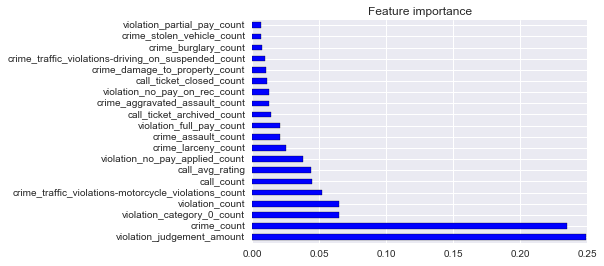

In [288]:
feat_imp = pd.Series(clf.feature_importances_, index=X.columns)
feat_imp.sort_values(inplace=True, ascending=False)
feat_imp.head(20).plot(kind='barh', title='Feature importance')

In [289]:
sum(clf.predict(X_test) == y_test) / float(len(y_test))

0.73826714801444049

In [290]:
sum(clf.predict(X_train) == y_train) / float(len(y_train))

0.8319143446852425

In [291]:
from sklearn.metrics import roc_curve, roc_auc_score

In [292]:
pred_probs = clf.predict_proba(X_test)[:, 1]

In [295]:
round(roc_auc_score(y_test, pred_probs), 5)

0.83157

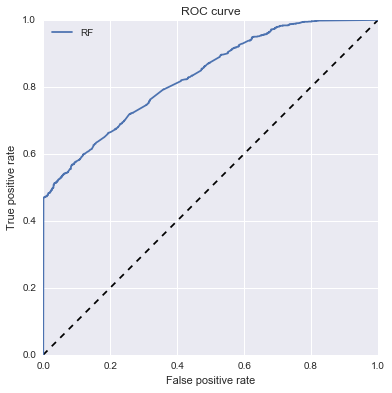

In [294]:
fpr, tpr, thresholds = roc_curve(y_test, pred_probs, pos_label=1)
plt.figure(figsize=(6, 6), dpi=200)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()